## Define library imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Define functions

In [ ]:
"""These functions were developed using data obtained from the Brazilian National Laboratory of Synchrotron Light in IPÊ beamline.
    Code write by Giordano Bispo"""

In [ ]:
def read_spec_xas(filename):
    """
    Reads a .spec file from a directory and returns a dictionary 
    containing numpy arrays for each column.

    Parameters:
        filename (str): Name of the .spec file.

    Returns:
        dict: Dictionary where keys are column names and values are 1D numpy arrays.
    """
    path = Path(filename)
    
    if not path.exists(): #erro
        raise FileNotFoundError(f"File not found in current directory: {path.absolute()}")

    headers = []
    # Read the header line starting with #L
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('#L'):
                headers = line.replace('#L', '').strip().split()
                break
    
    if not headers:
        raise ValueError("Header line '#L' not found in the file.")

    # Load data into a numpy matrix ignoring comment lines
    data_matrix = np.loadtxt(path, comments='#')
    
    # Create a dictionary mapping column names to data arrays
    data_dict = {name: data_matrix[:, i] for i, name in enumerate(headers)}
    
    print(f"Successfully read '{path.name}'. Available columns: {headers}")
    return data_dict

In [ ]:

def normalization(data_dict, mode='TEY', norm=False, minimum=None, maximum=None, save=False, filename=None):
    """
    Calculates the absorption signal, normalize, plots the result, and optionally saves it to a .txt file.

    Parameters:
        data_dict (dict): Dictionary returned by read_spec_xas.
        mode (str): 'TEY' for Total Electron Yield or 'FY' for Fluorescence Yield.
        norm (bool): If True, performs step normalization (0 to 1). If False, plots raw Signal/I0.
        minimum (tuple): (start, end) eV for the region defined as 0 (Required if norm=True).
        maximum (tuple): (start, end) eV for the region defined as 1 (Required if norm=True).
        Warning: the values ​​must match the energy values ​​in the .spec file.
        save (bool): If True, saves the data to a .txt file in the script directory.
        filename (str): Original filename (used to generate the output filename if saving).

    Returns:
        tuple: (energy_array, final_data_array)
    """
    # Check for necessary columns
    required_cols = ['energy', 'RIXS_i0']
    if mode == 'TEY':
        signal_col = 'RIXS_tey' #written like this in the IPE beamline .spec file.
    elif mode == 'FY':
        signal_col = 'RIXS_fy'
    else:
        raise ValueError("Mode must be 'TEY' or 'FY'")

    if not all(col in data_dict for col in required_cols + [signal_col]):
        raise KeyError(f"Missing columns in data. Required: {required_cols + [signal_col]}")

    energy = data_dict['energy']
    signal = data_dict[signal_col]
    i0 = data_dict['RIXS_i0']

    # 1. Calculate Physical Absorption (Signal / I0) avoiding division by zero
    absorption = np.divide(signal, i0, out=np.zeros_like(signal), where=i0!=0)

    plt.figure(figsize=(10, 6))

    # 2. Check if Step Normalization is requested
    if norm:
        if minimum is None or maximum is None:
            print("Error: 'minimum' and 'maximum' ranges are required when norm=True.")
            return energy, absorption

        # Create boolean masks for the regions
        mask_0 = (energy >= minimum[0]) & (energy <= minimum[1])
        mask_1 = (energy >= maximum[0]) & (energy <= maximum[1])

        if not np.any(mask_0) or not np.any(mask_1):
            print("Error: One of the defined energy ranges contains no data points.")
            return energy, absorption

        # Calculate mean values for 0 and 1 references
        mu_0 = np.mean(absorption[mask_0])
        mu_1 = np.mean(absorption[mask_1])

        # Apply normalization formula: (y - y0) / (y1 - y0)
        final_data = (absorption - mu_0) / (mu_1 - mu_0)
        ylabel = 'Normalized Intensity (Arb. Units)'
        title = f'Step Normalization ({mode})'

        # Visualization specifics for normalization
        plt.axvspan(minimum[0], minimum[1], color='red', alpha=0.2, label='Reference 0')
        plt.axvspan(maximum[0], maximum[1], color='green', alpha=0.2, label='Reference 1')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
        plt.axhline(1, color='green', linestyle='--', linewidth=0.8)

    else:
        # If norm=False, just use the raw Signal/I0 ratio
        final_data = absorption
        ylabel = f'Absorption_{mode} (Signal/I0)'
        title = f'Absorption_{mode} vs Energy (Raw)'

    # Plotting
    plt.plot(energy, final_data, color='black' if norm else 'blue', linewidth=2, label='Data')
    
    plt.xlabel('Energy (eV)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    # 3. Save Logic
    if save:
        # Construct output filename
        if filename:
            base_name = Path(filename).stem
            suffix = "norm" if norm else "raw"
            output_file = f"{base_name}_{mode}_{suffix}.txt"
        else:
            output_file = f"xas_output_{mode}.txt"

        # Save Data
        header = "Energy(eV)\tIntensity"
        data_to_save = np.column_stack((energy, final_data))
        np.savetxt(output_file, data_to_save, header=header, fmt='%.6f', delimiter='\t')
        print(f"Data successfully saved to: {Path(output_file).absolute()}")

    return energy, final_data

# Runing code

Successfully read '0058.spec'. Available columns: ['energy', 'und', 'Epoch_float', 'Epoch', 'energy_user_setpoint', 'und_setpoint', 'RIXS_tey', 'RIXS_fy', 'RIXS_pd', 'RIXS_i0']


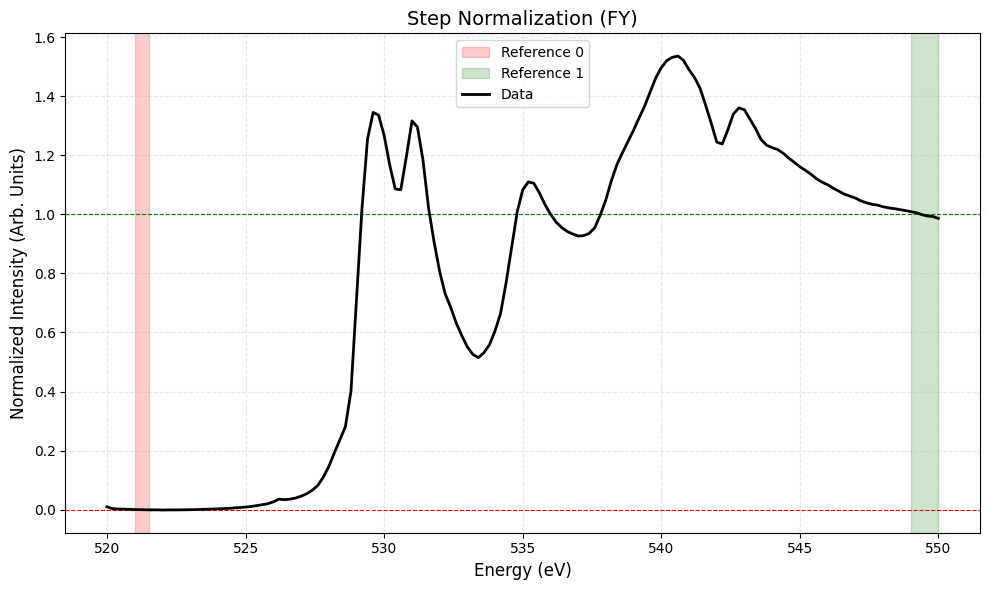

In [12]:
xas = Path(r'C:\Users\gfred\OneDrive\gases_Arnaldo\0058.spec')
data = read_spec_xas(xas)

energy, result_data = normalization(
    data, 
    mode='FY', 
    norm=True, 
    minimum=(521, 521.5), 
    maximum=(549, 550),
    save=False,          # Enable saving
    filename='xas'   # Pass original name for auto-naming
)